# Symposium on Molecular Interactions Tutorials
## What is this?? (Session 2).
This is a Jupyter notebook. It runs Python, but also allows it to be interspersed with Markdown-formatted text, for a nice mixture of documentation and code.

The particular material below is Session 2 of the tutorials on free energy calculations and OpenMM, from Day 1 of the Symposium on Molecular Interactions (2017).

This content is available on the [symposium github repository](https://github.com/QCMM/workshop2017) at [https://github.com/QCMM/workshop2017](https://github.com/QCMM/workshop2017).

This material is a set of slides intended for presentation with RISE (for presentations from Jupyter notebooks). While it may be useful without RISE, it will also likely appear somewhat less verbose than it would if it were intended for use in written form.

## Authors/sources/acknowledgments
Author: David L. Mobley (UCI)

### Sources
- Much of content adapted from materials I have developed or am developing for my [Drug Discovery Computing Techniques class](https://github.com/mobleylab/drug-computing).

### Acknowledgments
- John Chodera and Nathan Lim for help with OpenMM
- OpenEye for help with OpenEye software, especially James Haigh

# Outline of this afternoon's second session
1. Some brief OpenMM basics (what's going on under the hood in Yank)
2. A simple example of a density calculation which stops when converged
3. Analyzing density results in this notebook
4. SMIRNOFF force fields, modifying the density calculation to use them

**To follow along**/run code: Open this Jupyter notebook in `solvation_free_energies/Session2.ipynb` via `jupyter notebook Session2.ipynb`. (See [prerequisites](../prerequisites.md) if you aren't using preinstalled software.) This is cumulative, building on `Session1.ipynb`.



# Generate some input files we'll use

- We want some inputs to work with as we see how OpenMM works
- And for our sample density calculation
- [`SolvationToolkit`](https://github.com/mobleylab/SolvationToolkit) provides simple wrappers for building arbitrary mixtures
  - OpenEye toolkits
  - [`packmol`](https://github.com/mcubeg/packmol)
  - GAFF small molecule force field (and TIP3P or TIP4P, etc. for water)

Let's build a system to use later

In [39]:
from solvationtoolkit.solvated_mixtures import *
mixture = MixtureSystem('mixtures')
mixture.addComponent(label='phenol', smiles='c1ccc(cc1)O', number=1)
mixture.addComponent(label='toluene', smiles='Cc1ccccc1', number=10)
mixture.addComponent(label='cyclohexane', smiles='C1CCCCC1', number=100)
#Generate output files for AMBER
mixture.build(amber = True)

/Users/dmobley/anaconda3/envs/workshop_test/lib/python3.6/site-packages/pandas/io/parsers.py:2218: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/dmobley/anaconda3/envs/workshop_test/lib/python3.6/site-packages/pandas/io/parsers.py:2220: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())



# Mixture 

tolerance 2.000000
filetype pdb
output /var/folders/41/7d3rylg503n8nt_tn0hz6v8c0000gn/T/tmplhm4xyx2/tmp9yz9jwdt.pdb
add_amber_ter


structure /var/folders/41/7d3rylg503n8nt_tn0hz6v8c0000gn/T/tmplhm4xyx2/tmpn4thi8dz.pdb
  number 1 
  inside box 0. 0. 0. 25.521266 25.521266 25.521266
end structure

structure /var/folders/41/7d3rylg503n8nt_tn0hz6v8c0000gn/T/tmplhm4xyx2/tmp7j1f1b2x.pdb
  number 10 
  inside box 0. 0. 0. 25.521266 25.521266 25.521266
end structure

structure /var/folders/41/7d3rylg503n8nt_tn0hz6v8c0000gn/T/tmplhm4xyx2/tmp4ntd_h95.pdb
  number 100 
  inside box 0. 0. 0. 25.521266 25.521266 25.521266
end structure


source leaprc.gaff
source oldff/leaprc.ff99SB
ZSF = loadmol2 in0.mol2
ZFO = loadmol2 in1.mol2
ZQE = loadmol2 in2.mol2
box = loadPdb tbox.pdb
loadamberparams in0.frcmod
loadamberparams in1.frcmod
loadamberparams in2.frcmod
setbox box centers
saveAmberParm box out.prmtop out.inpcrd
quit



# OpenMM is more of a simulation toolkit than a simulation package
- Easy-to-use Python API
- Very fast calculations on GPUs (but slow on CPUs)
- Really easy to implement new techniques, do new science
- Key ingredients in a calculation:
    - `Topology`
    - `System`
    - `Simulation` (takes `System`, `Topology`, `Integrator`; contains positions)

## `Topology`: Chemical composition of your system

- Atoms, bonds, etc.
- Can be loaded from some common file formats such as PDB, mol2
- Can be created from OpenEye molecule via [`oeommtools`](https://github.com/oess/oeommtools), such as [`oeommtools.utils.oemol_to_openmmTop`](https://github.com/oess/oeommtools/blob/master/oeommtools/utils.py#L17)
    - Side note: An OE "molecule" can contain more than one molecule, so can contain protein+ligand+solvent for example
- Tangent: Try to retain bond order info if you have it (e.g. from a mol2)

In [4]:
# Example Topology generation from a couple mechanisms:

# Load a PDB
from simtk.openmm.app import PDBFile
pdb = PDBFile('sample_files/T4-protein.pdb')
t4_topology = pdb.topology

In [35]:
# Load a mol2: MDTraj supports a variety of file formats including mol2
import mdtraj
traj = mdtraj.load('sample_files/mobley_20524.mol2')
# MDTraj objects contain a Topology, but an MDTraj topology; they support conversion to OpenMM
traj.topology.to_openmm()

# MDTraj can also handle PDB, plus trajectory formats which contain topology information
protein_traj = mdtraj.load('sample_files/T4-protein.pdb')
t4_topology = protein_traj.topology.to_openmm()
# And we can visualize with nglview (or drop out to VMD)
import nglview
view = nglview.show_mdtraj(protein_traj)
view

/Users/dmobley/anaconda3/envs/workshop_test/lib/python3.6/site-packages/pandas/io/parsers.py:2218: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/dmobley/anaconda3/envs/workshop_test/lib/python3.6/site-packages/pandas/io/parsers.py:2220: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


NGLWidget()

In [22]:
# Load AMBER gas phase topology
from simtk.openmm.app import *
prmtop = AmberPrmtopFile('sample_files/mobley_20524.prmtop')
print("Topology has %s atoms" % prmtop.topology.getNumAtoms())

# Gromacs files can be loaded by GromacsTopFile and GromacsGroFile but you need topology/coordinate files
# which don't have include statements, or a GROMACS installation

Topology has 13 atoms


In [36]:
# Load an OEMol and convert (note advantage over MDTraj for bond order, etc.)

from openeye.oechem import *
from oeommtools.utils import *
mol = OEMol()
istream = oemolistream( 'sample_files/mobley_20524.mol2')
OEReadMolecule(istream, mol)
istream.close()

# Convert OEMol to Topology using oeommtools -- so you can get a topology from almost any format OE supports
topology, positions = oemol_to_openmmTop(mol)
print(topology.getNumAtoms())

13


## `System`: Your parameterized system
- Often generated by `createSystem`, but requires OpenMM know how to assign parameters
  - Easy for standard biomolecules (proteins, nucleic acids), waters ions
  - OpenMM FFXML files used; available for many common FFs
  - More complex for general small molecules
- Can also be loaded from common file formats such as GROMACS, AMBER
  - useful if you set up for AMBER or GROMACS
- We have new open forcefield effort that provides new force fields with an `openforcefield.createSystem` operator; generates OpenMM Systems.

In [37]:
# Example system creation
#From OpenMM Docs: http://docs.openmm.org/latest/userguide/application.html#running-simulations
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from sys import stdout

# Example System creation using OpenMM XML force field libraries -- good for biomolecules, ions, water
pdb = PDBFile('sample_files/input.pdb')
forcefield = ForceField('amber99sb.xml', 'tip3p.xml')
system = forcefield.createSystem(pdb.topology, nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer, constraints=HBonds)


In [146]:
# Or you could set up your own molecule for simulation with e.g. GAFF using AmberTools

from openmoltools.amber import *
# Generate GAFF-typed mol2 file and AMBER frcmod file using AmberTools
gaff_mol2_file, frcmod_file = run_antechamber('phenol', 'sample_files/mobley_20524.mol2')
# Generate AMBER files
prmtop_name, inpcrd_name = run_tleap( 'phenol', gaff_mol2_file, frcmod_file)
print("Generated %s and %s" % (prmtop_name, inpcrd_name))

# Create System -- in this case, single molecule in gas phase
prmtop = AmberPrmtopFile( prmtop_name)
inpcrd = AmberInpcrdFile( inpcrd_name)
system = prmtop.createSystem(nonbondedMethod = NoCutoff, nonbondedCutoff = NoCutoff, constraints = HBonds)

Generated /Users/dmobley/github/workshop2017/Free_energy_day1/OpenMM/phenol.prmtop and /Users/dmobley/github/workshop2017/Free_energy_day1/OpenMM/phenol.inpcrd


In [147]:
# Load the mixture we generated above in Section 3
file_prefix = 'mixtures/amber/phenol_toluene_cyclohexane_1_10_100'
prmtop = AmberPrmtopFile( file_prefix+'.prmtop')
inpcrd = AmberInpcrdFile( file_prefix+'.inpcrd')
# Create system: Here, solution phase with periodic boundary conditions and constraints
system = prmtop.createSystem(nonbondedMethod = PME, nonbondedCutoff = 1*nanometer, constraints = HBonds)

#You can visualize the above with VMD, or we can do:
traj = mdtraj.load( file_prefix + '.inpcrd', top = file_prefix + '.prmtop')
view = nglview.show_mdtraj(traj)
view

NGLWidget()

## `Simulation`: The system, topology, and positions you're simulating, under what conditions
- Could be for energy minimization, or different types of dynamics
- Has an integrator attached (even if just minimizing), including temperature
- `context` -- including positions, periodic box if applicable, etc.
- If dynamics, has:
  - timestep
  - velocities
- potentially also has reporters which store properties like energies, trajectory snapshots, etc.


### Let's take that last `System` we set up and energy minimize it
(The mixture of toluene, phenol, and cyclohexane we generated originally)

In [148]:
# Prepare the integrator
integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)

In [149]:
# Prep the simulation
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)

In [150]:
# Get and print initial energy
state = simulation.context.getState(getEnergy = True)
energy = state.getPotentialEnergy() / kilocalories_per_mole
print("Energy before minimization (kcal/mol): %.2g" % energy)

# Energy minimize
simulation.minimizeEnergy()

# Get and print final energy
state = simulation.context.getState(getEnergy=True, getPositions=True)
energy = state.getPotentialEnergy() / kilocalories_per_mole
print("Energy after minimization (kcal/mol): %.2g" % energy)

Energy before minimization (kcal/mol): 1.4e+11
Energy after minimization (kcal/mol): -5.3e+02


In [151]:
# While we're at it, why don't we just run a few steps of dynamics
simulation.reporters.append(PDBReporter('sample_files/mixture_output.pdb', 100))
simulation.reporters.append(StateDataReporter(stdout, 100, step=True,
        potentialEnergy=True, temperature=True))
simulation.step(1000) # Runs 1000 steps of dynamics
state = simulation.context.getState(getEnergy=True, getPositions=True)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,-1215.8894199668725,58.10464850643278
200,-366.7503188383687,102.00443793670226
300,425.4568995775537,135.43983542119014
400,860.8855565817614,171.76118053266964
500,1382.2184374274318,188.76826657021698
600,1744.558091576286,216.48597131874777
700,2111.807767295869,225.20441859166132
800,2305.5666515286575,244.39524829939592
900,2441.328118935232,258.43190464709005
1000,2567.078031609929,266.5830187799809


# A simple example of a density calculation which stops when converged

- We'll do a very simple density estimation
- This is not a recommended protocol since we're just jumping straight in to "production"
- But it illustrates how you can do this type of thing easily with OpenMM
- For production data, you'd precede by equilibration (usually NVT, then NPT, then production)

## The most bare-bones version

In [152]:
# We'll pick up that same system again, loading it up again so we can add a barostat before setting up the simulation
import simtk.openmm as mm
file_prefix = 'mixtures/amber/phenol_toluene_cyclohexane_1_10_100'
prmtop = AmberPrmtopFile( file_prefix+'.prmtop')
inpcrd = AmberInpcrdFile( file_prefix+'.inpcrd')
system = prmtop.createSystem(nonbondedMethod = PME, nonbondedCutoff = 1*nanometer, constraints = HBonds)

# Now add a barostat
system.addForce(mm.MonteCarloBarostat(1*atmospheres, 300*kelvin, 25))

# Set up integrator and simulation
integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)
simulation = Simulation(prmtop.topology, system, integrator)

# Let's pull the positions from the end of the brief "equilibration" we ran up above.
simulation.context.setPositions(state.getPositions())

# Set up a reporter to assess progress; will report every 100 steps (somewhat short)
prod_data_filename = os.path.join('sample_files', os.path.basename(file_prefix)+'.csv')
simulation.reporters.append(app.StateDataReporter( prod_data_filename, 100, step=True, potentialEnergy=True,
                                                  temperature=True, density=True))


In [153]:
# Set up for run; for a somewhat reasonable convergence threshold you probably want run_steps >= 2500
# and a density tolerance of 1e-3 or smaller; higher thresholds will likely result in early termination
# due to slow fluctuations in density.
# But that may take some time to run, so feel free to try higher also.
run_steps = 2500
converged = False
density_tolerance = 0.001
import pandas as pd
from pymbar import timeseries as ts

In [154]:
while not converged:
    simulation.step(run_steps)

    # Read data
    d = pd.read_csv(prod_data_filename, names=["step", "U", "Temperature", "Density"], skiprows=1)
    density_ts = np.array(d.Density)
    
    # Detect when it seems to have equilibrated and clip off the part prior
    [t0, g, Neff] = ts.detectEquilibration(density_ts)
    density_ts = density_ts[t0:]
    
    # Compute standard error of what's left
    density_mean_stderr = density_ts.std() / np.sqrt(Neff)

    # Print stats, see if converged
    print("Current density mean std error = %f g/mL" % density_mean_stderr)

    if density_mean_stderr < density_tolerance :
        converged = True
        print("...Convergence is OK; equilibration estimated to be achieved after data point %s\n" % t0)

Current density mean std error = 0.001193 g/mL
Current density mean std error = 0.001434 g/mL
Current density mean std error = 0.001333 g/mL
Current density mean std error = 0.002480 g/mL
Current density mean std error = 0.001770 g/mL
Current density mean std error = 0.002529 g/mL
Current density mean std error = 0.002182 g/mL
Current density mean std error = 0.002536 g/mL
Current density mean std error = 0.003708 g/mL
Current density mean std error = 0.003392 g/mL
Current density mean std error = 0.001015 g/mL
Current density mean std error = 0.002806 g/mL
Current density mean std error = 0.002009 g/mL
Current density mean std error = 0.002594 g/mL
Current density mean std error = 0.002477 g/mL
Current density mean std error = 0.002037 g/mL
Current density mean std error = 0.003465 g/mL
Current density mean std error = 0.002491 g/mL
Current density mean std error = 0.002409 g/mL
Current density mean std error = 0.002008 g/mL
Current density mean std error = 0.002182 g/mL
Current densi

Current density mean std error = 0.001056 g/mL
Current density mean std error = 0.001051 g/mL
Current density mean std error = 0.001044 g/mL
Current density mean std error = 0.001038 g/mL
Current density mean std error = 0.001032 g/mL
Current density mean std error = 0.001027 g/mL
Current density mean std error = 0.001025 g/mL
Current density mean std error = 0.001021 g/mL
Current density mean std error = 0.001017 g/mL
Current density mean std error = 0.001014 g/mL
Current density mean std error = 0.001007 g/mL
Current density mean std error = 0.001002 g/mL
Current density mean std error = 0.000996 g/mL
...Convergence is OK; equilibration estimated to be achieved after data point 0



# Analyzing density results in this notebook

- The above may take some time to converge
- (You can set the threshold higher, which may lead to apparently false convergence)
- Here we'll analyze some sample density data I've provided

## Matplotlib is quite nice for analysis

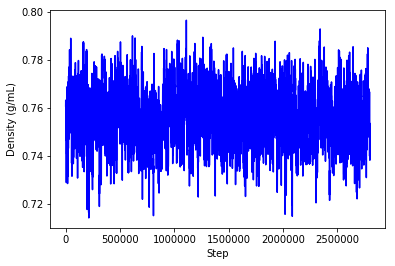

In [167]:
# Prep matplotlib/pylab to display here
%matplotlib inline
from pylab import *

# Load density

d = pd.read_csv('density_simulation/prod/phenol_toluene_cyclohexane_1_10_100_prod.csv', names=["step", "U", "Temperature", "Density"], skiprows=1)

# Plot instantaneous density

xlabel('Step')
ylabel('Density (g/mL)')
plot( np.array(d.step), np.array(d.Density), 'b-')

In [174]:
#Detect equilibration
density_ts = np.array(d.Density)
[t0, g, Neff] = ts.detectEquilibration(density_ts)

# Clip out unequilibrated region
density_ts = density_ts[t0:]
stepnrs = np.array(d.step[t0:])

# Compute mean density up to the present at each time, along with associated uncertainty
mean_density = [ density_ts[0:i].mean() for i in range(2, len(density_ts)) ]
mean_density_stderr = [ ]
for i in range(2,len(density_ts)):
    g = ts.statisticalInefficiency( density_ts[0:i])
    stderr = density_ts[0:i].std()/sqrt(i/g)
    mean_density_stderr.append(stderr)

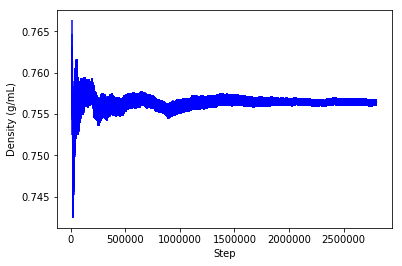

Experimental density of cyclohexane is 0.78 g/mL at 20C


In [173]:
# Plot
figure()
errorbar(stepnrs[2:], mean_density, yerr=mean_density_stderr, fmt='b-' )
xlabel('Step')
ylabel('Density (g/mL)')
show()
print("Experimental density of cyclohexane is 0.78 g/mL at 20C" ) # per PubChem, https://pubchem.ncbi.nlm.nih.gov/compound/cyclohexane#section=Solubility

# The density calculation could use an alternate SMIRNOFF force field

- A new approach to force fields
- Uses direct chemical perception rather than atom typing
- Simpler, more extensible, easier to modify
- See `github.com/openforcefield/openforcefield` and `openforcefield.org` for more
- Prototype small molecule force field `smirnoff99Frosst` somewhat comparable to GAFF
- Input: OpenMM Topology of system, OEMols of components

In [177]:
# Load OEMols of components:
indir = 'mixtures'
monomer_files = [ os.path.join( indir, 'monomers', name+'.mol2') for name in ['phenol', 'toluene', 'cyclohexane']]
monomers = []
for fname in monomer_files:
    ifile = oemolistream( fname )
    mol = OEMol()
    OEReadMolecule(ifile, mol)
    monomers.append(mol)
    ifile.close()

In [178]:
# Load Topology of mixture
pdb = PDBFile( os.path.join( indir, 'packmol_boxes', 'phenol_toluene_cyclohexane_1_10_100.pdb'))

In [182]:
# Parameterize our system
from openforcefield.typing.engines.smirnoff import *
ff = ForceField('forcefield/smirnoff99Frosst.ffxml', 'sample_files/hbonds.ffxml')
system = ff.createSystem(pdb.topology, monomers, nonbondedMethod = PME, nonbondedCutoff = 1*nanometer)

In [183]:
# Prepare the integrator
integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)
# Prep the simulation
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)

In [184]:
# Get and print initial energy
state = simulation.context.getState(getEnergy = True)
energy = state.getPotentialEnergy() / kilocalories_per_mole
print("Energy before minimization (kcal/mol): %.2g" % energy)

# Energy minimize
simulation.minimizeEnergy()

# Get and print final energy
state = simulation.context.getState(getEnergy=True, getPositions=True)
energy = state.getPotentialEnergy() / kilocalories_per_mole
print("Energy after minimization (kcal/mol): %.2g" % energy)

Energy before minimization (kcal/mol): 2.4e+06
Energy after minimization (kcal/mol): 3e+03


## At this point, we could proceed with a density calculation as we did above

- OpenMM is flexible
- Once you get something IN, the origin doesn't really matter
- Provides powerful way to get going with new things, implement new methods, etc.
- OpenMM systems can be dumped to various other formats, such as via the useful `ParmEd` tool.